# Assignment 2: Evaluating Classification Models
## Christopher Rico
## MSDS 422 

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

Scikit Learn documentation for this assignment:

* http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
* http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* http://scikit-learn.org/stable/modules/model_evaluation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html


In [0]:
#Christopher Rico
#MSDS422 Assignment 2
#10/6/19

# Dev Environment Setup


---



In [0]:
#--------------------------------------------------------------------
#                       Dev Environment Setup
#--------------------------------------------------------------------

# Jump-Start for the Bank Marketing Study
# as described in Marketing Data Science: Modeling Techniques
# for Predictive Analytics with R and Python (Miller 2015)

# jump-start code revised by Thomas W. Milller (2018/10/07)

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 42

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [0]:
# define function for correlation heat map setup for seaborn
# modified to allow for square heatmaps as well as triangle ones
def corr_chart(corr, tri=True):
    if tri is True:
        #screen top half to get a triangle
        top = np.zeros_like(corr, dtype=np.bool)
        top[np.triu_indices_from(top)] = True
    else:
        top = np.zeros_like(corr, dtype=np.bool)
        
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm',
        center = 0, square=True,
        linewidths=.5, cbar_kws={'shrink':.5},
        annot = True, annot_kws={'size': 9}, fmt = '.3f')
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')
    plt.savefig('plot-corr-map.pdf',
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
        orientation='portrait', papertype=None, format=None,
        transparent=True, pad_inches=0.25, frameon=None)

# Getting and Examining Data


---



In [0]:
#--------------------------------------------------------------------
#                     Getting and Examining Data
#--------------------------------------------------------------------

#get data from github raw file
url = 'https://raw.githubusercontent.com/christophrico/MSDS_422/master/assign-2/bank.csv'
bank = pd.read_csv(url, sep=';')

# examine the shape of original input data
print(bank.shape) 

(4521, 17)


In [0]:
# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
print(bank.shape)

(4521, 17)


In [0]:
# look at the list of column names, note that y is the response
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [0]:
# look at the beginning of the DataFrame
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [0]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [0]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
response     object
dtype: object

# Data Transformation


---



In [0]:
#--------------------------------------------------------------------
#                        Data Transformation
#--------------------------------------------------------------------

#The shape of this dataframe makes it difficult 
#to do EDA on categorical columns.
#Let's transform it to a better layout.

# start by converting text no/yes to integer 0/1
bank = bank.replace({'no' : 0, 'yes' : 1})

#create a copied df
df_bank = bank.copy()

#now we need to break out the categorical columns
dummies = ['job', 'marital', 'education','contact', 'month','poutcome']

#create dummy columns for each categorical column value
for col in dummies:
  dummies = pd.get_dummies(df_bank[col], prefix='val', prefix_sep='_')
  col_dummies = dummies.columns.values
  
  #then append new columns to dataframe
  for n, value in enumerate(col_dummies):
    df_bank[value] = dummies.iloc[:,n]
    
#drop categorical columns and keep dummy columns
df_bank = df_bank.drop(columns=['job', 'marital', 'education',\
                                'contact','month','poutcome'])

#let's have a look at what we got
df_bank.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'response', 'val_admin.',
       'val_blue-collar', 'val_entrepreneur', 'val_housemaid',
       'val_management', 'val_retired', 'val_self-employed', 'val_services',
       'val_student', 'val_technician', 'val_unemployed', 'val_unknown',
       'val_divorced', 'val_married', 'val_single', 'val_primary',
       'val_secondary', 'val_tertiary', 'val_cellular', 'val_telephone',
       'val_apr', 'val_aug', 'val_dec', 'val_feb', 'val_jan', 'val_jul',
       'val_jun', 'val_mar', 'val_may', 'val_nov', 'val_oct', 'val_sep',
       'val_failure', 'val_other', 'val_success'],
      dtype='object')

In [0]:
#change order of columns so that response variable is furthest to the right
df_bank = df_bank[['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'val_admin.', 'val_blue-collar',
       'val_entrepreneur', 'val_housemaid', 'val_management',
       'val_retired', 'val_self-employed', 'val_services',
       'val_student', 'val_technician', 'val_unemployed',
       'val_unknown', 'val_divorced', 'val_married', 'val_single',
       'val_primary', 'val_secondary', 'val_tertiary', 'val_cellular',
       'val_telephone', 'val_apr', 'val_aug', 'val_dec', 'val_feb',
       'val_jan', 'val_jul', 'val_jun', 'val_mar', 'val_may',
       'val_nov', 'val_oct', 'val_sep', 'val_failure', 'val_other',
       'val_success','response']]

df_bank.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,val_admin.,val_blue-collar,val_entrepreneur,val_housemaid,val_management,val_retired,val_self-employed,val_services,val_student,val_technician,val_unemployed,val_unknown,val_divorced,val_married,val_single,val_primary,val_secondary,val_tertiary,val_cellular,val_telephone,val_apr,val_aug,val_dec,val_feb,val_jan,val_jul,val_jun,val_mar,val_may,val_nov,val_oct,val_sep,val_failure,val_other,val_success,response
0,30,0,1787,0,0,19,79,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,33,0,4789,1,1,11,220,1,339,4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,30,0,1476,1,1,3,199,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,59,0,0,1,0,5,226,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# EDA


---



<function matplotlib.pyplot.show>

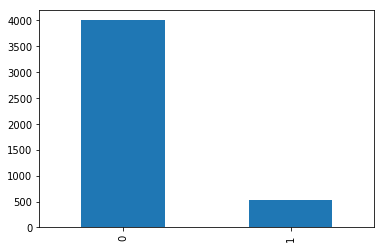

In [0]:
#--------------------------------------------------------------------
#                      Exploratory Data Analysis
#--------------------------------------------------------------------

#look at the yes/no responses
df_bank['response'].value_counts().plot(kind="bar")
plt.show

In [0]:
#what does the average yes/no person look like?
mean_table = df_bank.groupby('response').mean()
mean_table

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,val_admin.,val_blue-collar,val_entrepreneur,val_housemaid,val_management,val_retired,val_self-employed,val_services,val_student,val_technician,val_unemployed,val_unknown,val_divorced,val_married,val_single,val_primary,val_secondary,val_tertiary,val_cellular,val_telephone,val_apr,val_aug,val_dec,val_feb,val_jan,val_jul,val_jun,val_mar,val_may,val_nov,val_oct,val_sep,val_failure,val_other,val_success
response,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,40.998000,0.016750,1403.211750,0.584750,0.162000,15.948750,226.347500,2.862250,36.006000,0.471250,0.105000,0.219250,0.038250,0.024500,0.20950,0.044000,0.040750,0.094750,0.016250,0.171250,0.028750,0.842000,0.112750,0.63000,0.257250,0.153500,0.51525,0.289250,0.620000,0.064250,0.059250,0.138500,0.002750,0.046000,0.03300,0.161250,0.119000,0.007000,0.326250,0.087500,0.010750,0.00875,0.106750,0.039750,0.011500
1,42.491363,0.017274,1571.955854,0.422265,0.082534,15.658349,552.742802,2.266795,68.639155,1.090211,0.111324,0.132438,0.028791,0.026871,0.25144,0.103647,0.038388,0.072937,0.036468,0.159309,0.024952,0.646833,0.147793,0.53167,0.320537,0.122841,0.47025,0.370441,0.798464,0.084453,0.107486,0.151631,0.017274,0.072937,0.03071,0.117083,0.105566,0.040307,0.178503,0.074856,0.071017,0.03263,0.120921,0.072937,0.159309


In [0]:
#let's flip this table and sort it
#so the vars with the biggest diff are at the top
mean_table_T = mean_table.copy
mean_table_T = mean_table.T
#turn the table into a df
df_mean_table_T = pd.DataFrame(mean_table_T)
#append a calculated column
df_mean_table_T['mean_diff'] = df_mean_table_T[1] - df_mean_table_T[0]
#and sort
df_mean_table_T = df_mean_table_T.sort_values('mean_diff', ascending = False)\
                              .reset_index(drop=False)


df_mean_table_T.head(10)

response,index,0,1,mean_diff
0,duration,226.34750,552.742802,326.395302
1,balance,1403.21175,1571.955854,168.744104
2,pdays,36.00600,68.639155,32.633155
3,age,40.99800,42.491363,1.493363
4,previous,0.47125,1.090211,0.618961
5,val_cellular,0.62000,0.798464,0.178464
6,val_success,0.01150,0.159309,0.147809
7,val_tertiary,0.28925,0.370441,0.081191
8,val_single,0.25725,0.320537,0.063287
9,val_oct,0.01075,0.071017,0.060267


<Figure size 432x288 with 0 Axes>

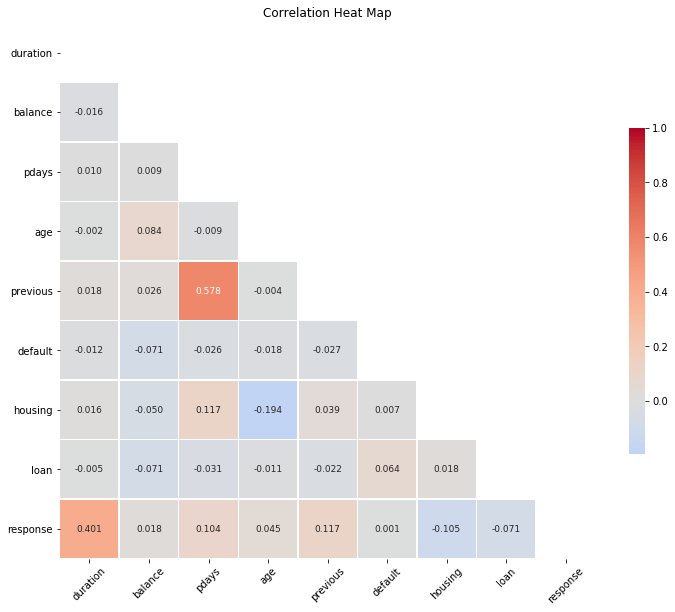

In [0]:
#let's get a correlation heatmap to see which explanatory variables scale together
select_exp_vars = ['duration', 'balance', 'pdays', 'age',\
                   'previous', 'default', 'housing', 'loan','response']

exp_vars = df_bank[select_exp_vars].corr()
corr_chart(corr = exp_vars)


# Modeling

---

In [0]:
#--------------------------------------------------------------------
#             Model Setup: Log Regression vs. Naive Bayes
#--------------------------------------------------------------------


#--------------------------------------------------------------------
#                           CROSS_FOLD_VAL
# Function to automate cross-fold validation between various models
# Input: model_data, a numpy array with response var last
#        classi_names, a list of the classifier names for printing
#        classi_paran, a list of the sklearn classifier instances
#        num_folds, int for the number of folds you want to run (default 5)
# Output: model performance per fold per classifier 
#         with AUROC value and chart
# Adapted from Scikit-Learn documentation
#--------------------------------------------------------------------

def cross_fold_val(model_data, classi_names, classi_params, num_folds=5):

  # set up numpy array for storing results
  cv_res = np.zeros((num_folds, len(classi_names)))
  
  #look at 3 different model's performance for each fold count
  kf = KFold(n_splits = num_folds, shuffle=False, random_state = RANDOM_SEED)
  fold_idx = 0

  for train_idx, test_idx in kf.split(model_data):
    print("___________________ FOLD INDEX {} ___________________"\
          .format(fold_idx))

    #explanatory vars are held at 0:model_data.shape[1]-1
    #and response vars are held at modeldata.shape[1]-1
    X_train = model_data[train_idx, 0:model_data.shape[1]-1]
    X_test = model_data[test_idx, 0:model_data.shape[1]-1]
    y_train = model_data[train_idx, model_data.shape[1]-1]
    y_test = model_data[test_idx, model_data.shape[1]-1]

    print("\n Input data shape:")
    print("X_train: {}".format(X_train.shape))
    print("X_test: {}".format(X_test.shape))
    print("y_train: {}".format(y_train.shape))
    print("y_test: {}".format(y_test.shape))


    #within each fold count, compare classifier performance
    classi_idx = 0
    for name, clf in zip(classi_names, classi_params):
      print("\n----- Classifier: {} -----".format(name))

      #fit on the training set
      clf.fit(X_train, y_train)
      #evaluate on the test set
      y_test_pred = clf.predict_proba(X_test)
      fold_classi_res = roc_auc_score(y_test, y_test_pred[:,1])

      #display ROC AUC and chart of ROC
      print("AUROC: {}".format(fold_classi_res))
      roc_chart(yT=y_test, yTP=y_test_pred)
      
      cv_res[fold_idx, classi_idx] = fold_classi_res

      classi_idx += 1
      #end inner loop

      
    fold_idx += 1
    print("___________________________________________________\n\n\n")  
    #end outer loop


  #print out accumulated results for each analysis
  cv_res_df = pd.DataFrame(cv_res)
  cv_res_df.columns = classi_names

  print("\n_____________ PERFORMANCE SUMMARY _____________")
  print("Average results from {}-fold cross-validation".format(num_folds))
  print("Comparison method:      AUROC")     
  print(cv_res_df.mean())

#end cross_fold_val

In [0]:
#--------------------------------------------------------------------
#                           ROC_CHART
# Function to generate AUROC chart for display
# Input: yT, 
#        yTP
# Adapted from seaborn and week 1 homework
#--------------------------------------------------------------------

def roc_chart(yT, yTP):
  logit_roc_auc = roc_auc_score(yT, yTP[:,1])
  fpr, tpr, thresholds = roc_curve(yT, yTP[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='(Area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

## Model Cross-Validation: Default, Housing, and Loan

In [0]:
#We want to compare these three classifiers:
#Logistic regression, Bernoulli Naive Bayes, and Gaussian Naive Bayes
classifiers = ["Logistic Regression",
               "Bernoulli NB",
               "Gaussian NB"]

classifiers_params = [LogisticRegression(solver='lbfgs'),
                      BernoulliNB(alpha=1.0,
                                 binarize=0.5,
                                 class_prior=[0.5, 0.5],
                                 fit_prior=False),
                       GaussianNB()]

In [0]:
#--------------------------------------------------------------------
#                       Model Cross-Validation
#                  Vars: Default, Housing, and Loan
#--------------------------------------------------------------------

# Gather three explanatory variables and response into a numpy array
# let's start with the suggested 3: default, housing, and loan
model_data_1 = np.array([np.array(df_bank['default']),
                       np.array(df_bank['housing']),
                       np.array(df_bank['loan']),
                       np.array(df_bank['response'])]).T

# examine the shape of model_data
print(model_data_1.shape)

(4521, 4)


___________________ FOLD INDEX 0 ___________________

 Input data shape:
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

----- Classifier: Logistic Regression -----
AUROC: 0.5878522062732588


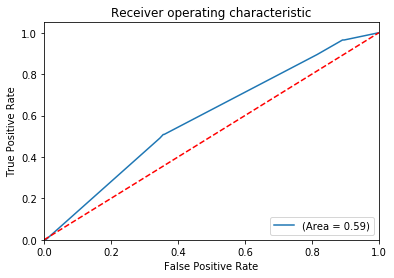


----- Classifier: Bernoulli NB -----
AUROC: 0.5878522062732588


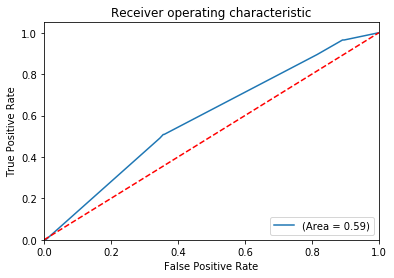


----- Classifier: Gaussian NB -----
AUROC: 0.589491405280879


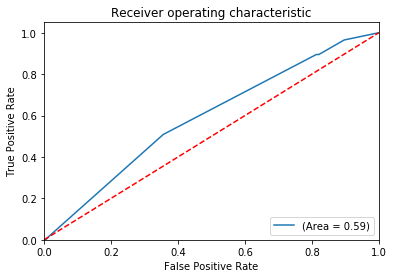

___________________________________________________



___________________ FOLD INDEX 1 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.633727778967659


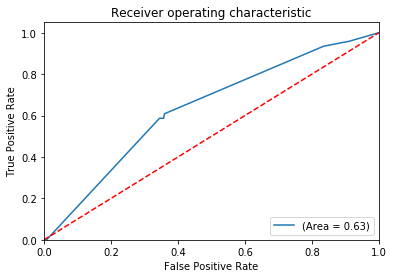


----- Classifier: Bernoulli NB -----
AUROC: 0.633727778967659


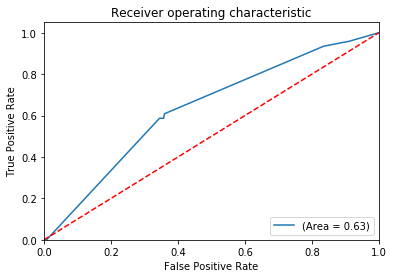


----- Classifier: Gaussian NB -----
AUROC: 0.6169147569072607


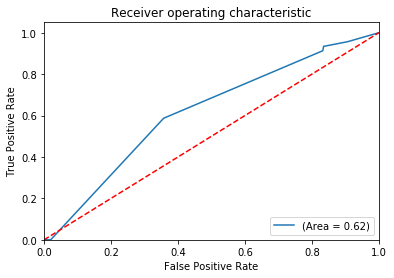

___________________________________________________



___________________ FOLD INDEX 2 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.6575354454752319


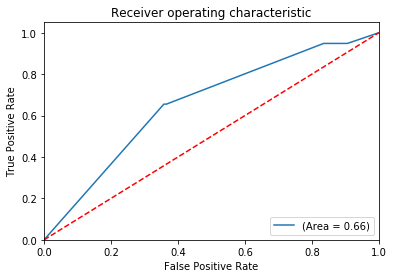


----- Classifier: Bernoulli NB -----
AUROC: 0.6575354454752319


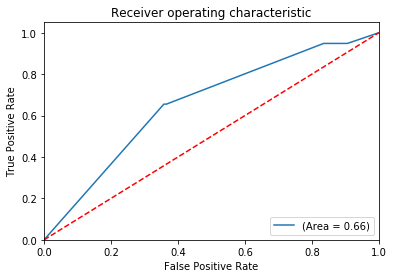


----- Classifier: Gaussian NB -----
AUROC: 0.6518029056537721


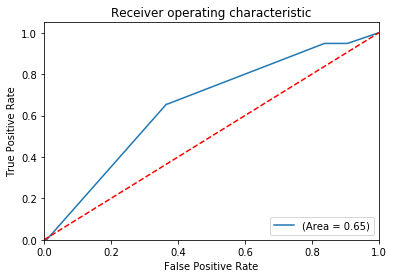

___________________________________________________



___________________ FOLD INDEX 3 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.6355648959335594


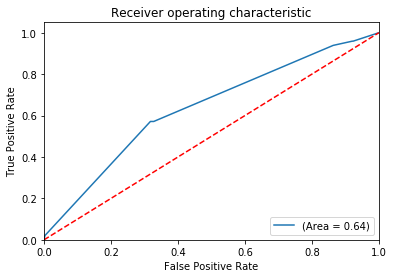


----- Classifier: Bernoulli NB -----
AUROC: 0.6373879576644552


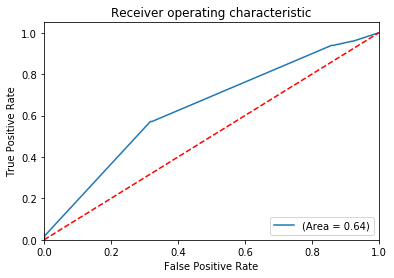


----- Classifier: Gaussian NB -----
AUROC: 0.6343495214462956


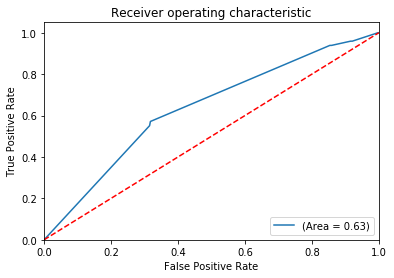

___________________________________________________



___________________ FOLD INDEX 4 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.5743993962517295


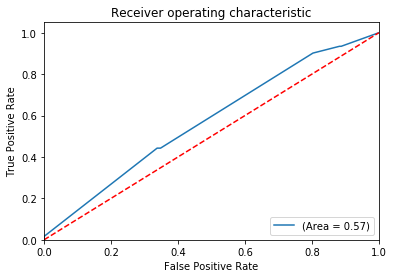


----- Classifier: Bernoulli NB -----
AUROC: 0.5743993962517295


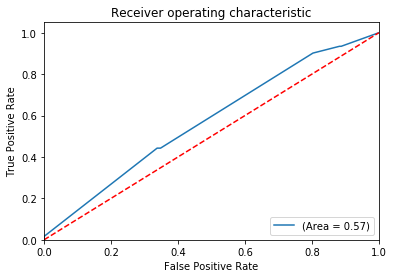


----- Classifier: Gaussian NB -----
AUROC: 0.5698712842228837


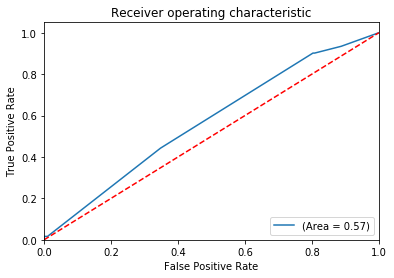

___________________________________________________



___________________ FOLD INDEX 5 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.5842383241350662


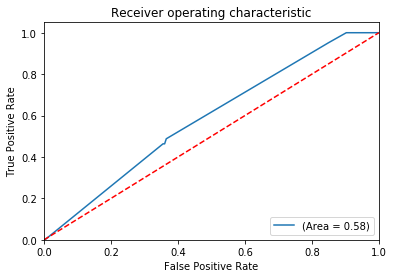


----- Classifier: Bernoulli NB -----
AUROC: 0.5746839950151327


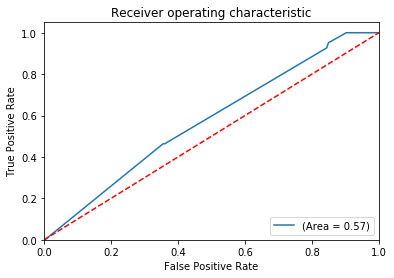


----- Classifier: Gaussian NB -----
AUROC: 0.575752180879473


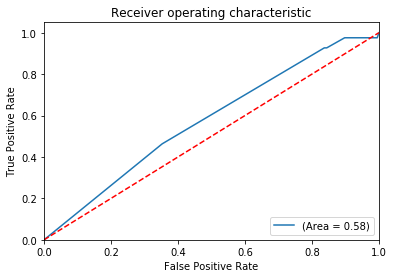

___________________________________________________



___________________ FOLD INDEX 6 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.5625116322352502


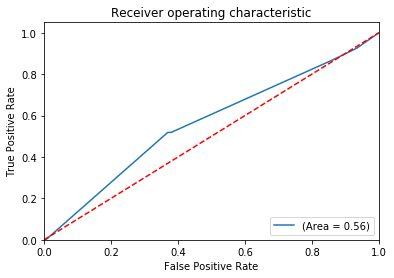


----- Classifier: Bernoulli NB -----
AUROC: 0.5625116322352502


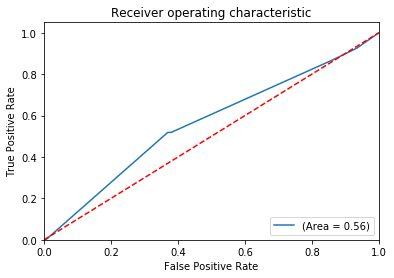


----- Classifier: Gaussian NB -----
AUROC: 0.5573003908431043


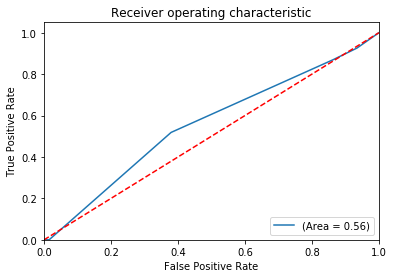

___________________________________________________



___________________ FOLD INDEX 7 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.7311441622103387


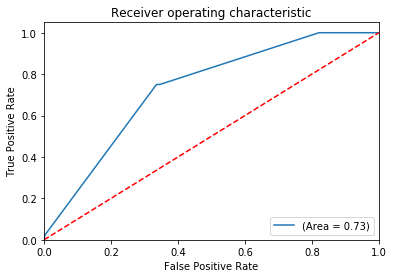


----- Classifier: Bernoulli NB -----
AUROC: 0.7311441622103387


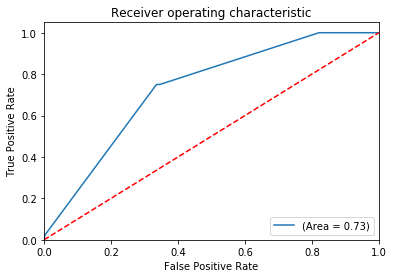


----- Classifier: Gaussian NB -----
AUROC: 0.7278019162210339


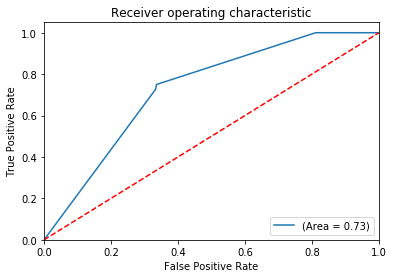

___________________________________________________



___________________ FOLD INDEX 8 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.5735328888258382


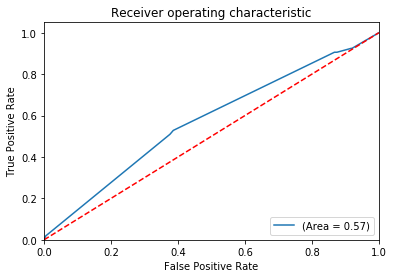


----- Classifier: Bernoulli NB -----
AUROC: 0.5735328888258382


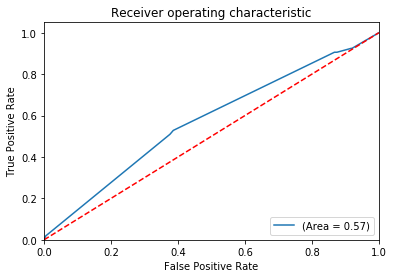


----- Classifier: Gaussian NB -----
AUROC: 0.557407670118693


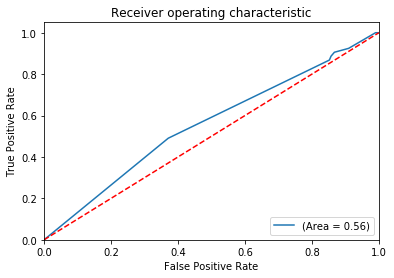

___________________________________________________



___________________ FOLD INDEX 9 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.5768204095921582


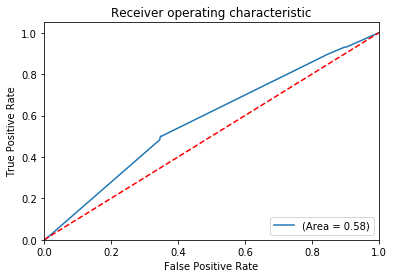


----- Classifier: Bernoulli NB -----
AUROC: 0.5778268860493612


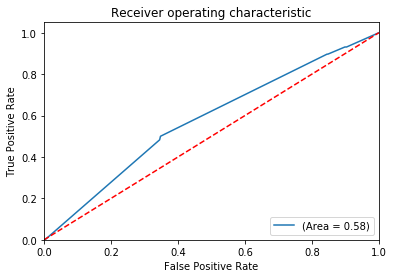


----- Classifier: Gaussian NB -----
AUROC: 0.5778268860493612


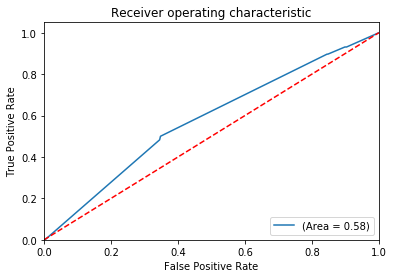

___________________________________________________




_____________ PERFORMANCE SUMMARY _____________
Average results from 10-fold cross-validation
Comparison method:      AUROC
Logistic Regression    0.611733
Bernoulli NB           0.611060
Gaussian NB            0.605852
dtype: float64


In [0]:
#compare the classifiers across different folds
cross_fold_val(model_data = model_data_1, classi_names = classifiers,\
               classi_params = classifiers_params, num_folds = 10)

## Model Cross-Validation: Duration, Balance, and Pdays

In [0]:
#--------------------------------------------------------------------
#                       Model Cross-Validation
#                  Vars: Duration, Balance, Pdays
#-------------------------------------------------------------------

# Let's try three other explanatory variables
# duration, balance, and pdays
model_data_2 = np.array([np.array(df_bank['duration']),
                       np.array(df_bank['balance']),
                       np.array(df_bank['pdays']),
                       np.array(df_bank['response'])]).T

# examine the shape of model_data
print(model_data_1.shape)

(4521, 4)


___________________ FOLD INDEX 0 ___________________

 Input data shape:
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

----- Classifier: Logistic Regression -----
AUROC: 0.7965178096757044


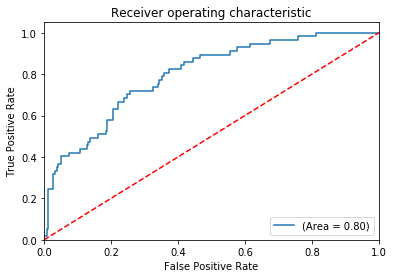


----- Classifier: Bernoulli NB -----
AUROC: 0.5822036150983518


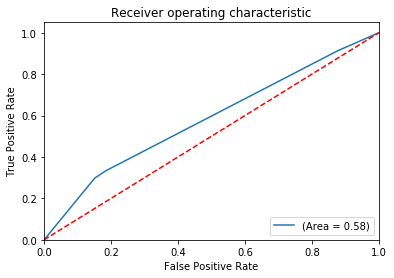


----- Classifier: Gaussian NB -----
AUROC: 0.7544745702640439


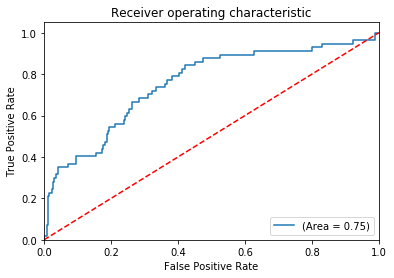

___________________________________________________



___________________ FOLD INDEX 1 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8341721996144785


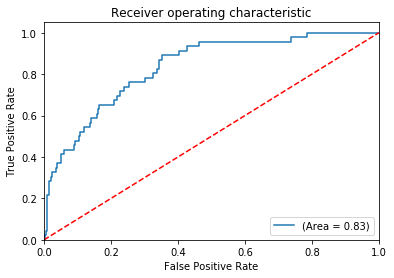


----- Classifier: Bernoulli NB -----
AUROC: 0.5903833797387021


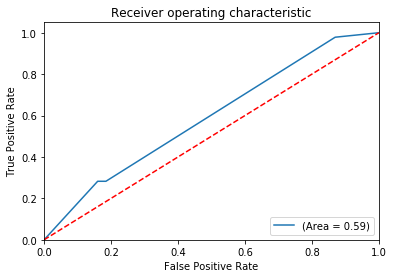


----- Classifier: Gaussian NB -----
AUROC: 0.7332940672520882


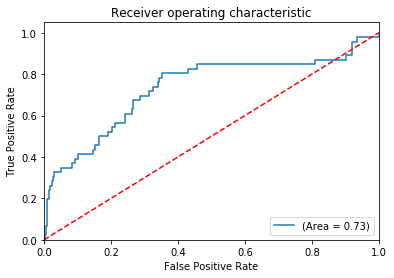

___________________________________________________



___________________ FOLD INDEX 2 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.7594958865744793


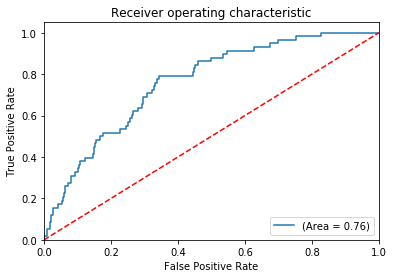


----- Classifier: Bernoulli NB -----
AUROC: 0.6370995974094171


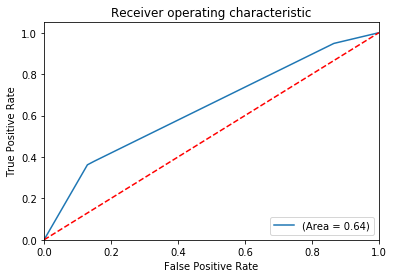


----- Classifier: Gaussian NB -----
AUROC: 0.7322335025380711


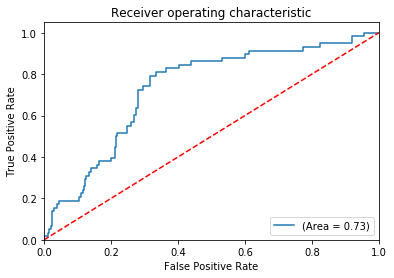

___________________________________________________



___________________ FOLD INDEX 3 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8054894414341418


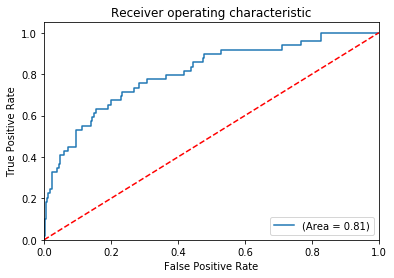


----- Classifier: Bernoulli NB -----
AUROC: 0.6107763204537399


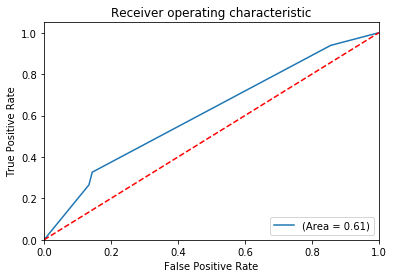


----- Classifier: Gaussian NB -----
AUROC: 0.781890920139768


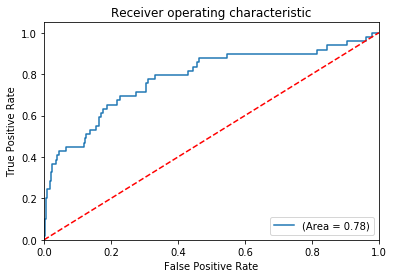

___________________________________________________



___________________ FOLD INDEX 4 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8576160328707392


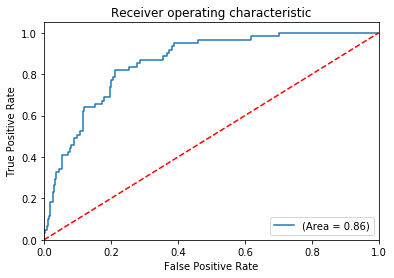


----- Classifier: Bernoulli NB -----
AUROC: 0.6395538971112322


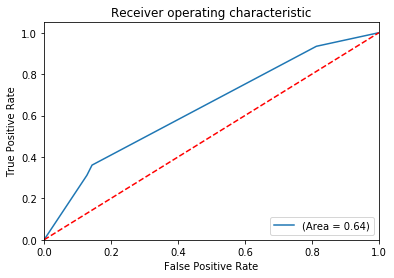


----- Classifier: Gaussian NB -----
AUROC: 0.8286025743155423


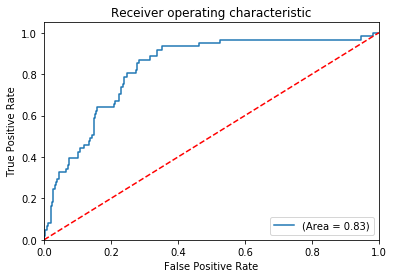

___________________________________________________



___________________ FOLD INDEX 5 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.883834787252982


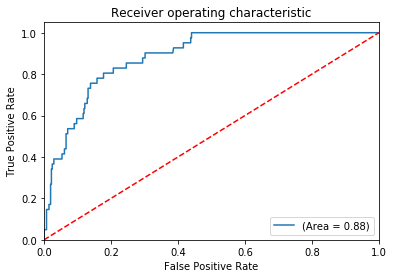


----- Classifier: Bernoulli NB -----
AUROC: 0.6735802029553143


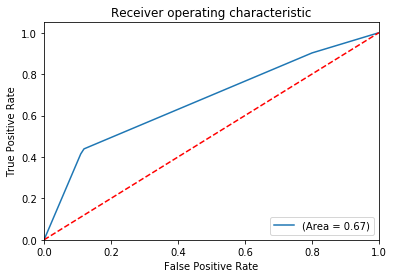


----- Classifier: Gaussian NB -----
AUROC: 0.8516705240045102


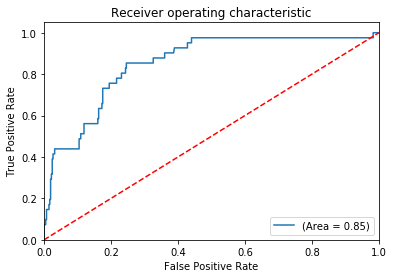

___________________________________________________



___________________ FOLD INDEX 6 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.820212171970966


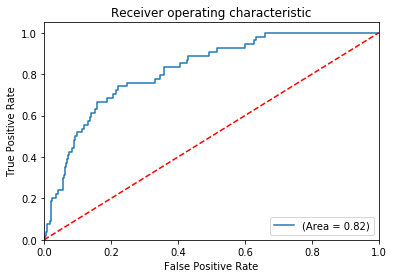


----- Classifier: Bernoulli NB -----
AUROC: 0.5881258142564676


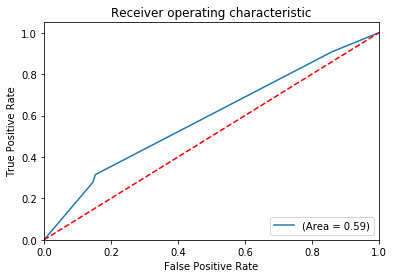


----- Classifier: Gaussian NB -----
AUROC: 0.7708449655685835


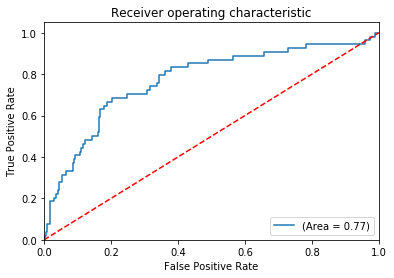

___________________________________________________



___________________ FOLD INDEX 7 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8792335115864528


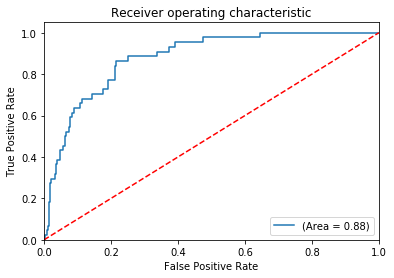


----- Classifier: Bernoulli NB -----
AUROC: 0.6298462566844919


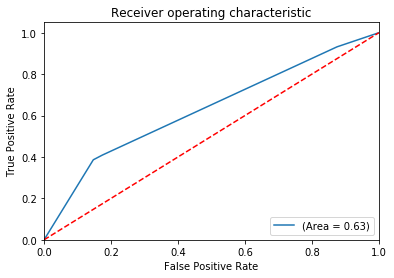


----- Classifier: Gaussian NB -----
AUROC: 0.82525623885918


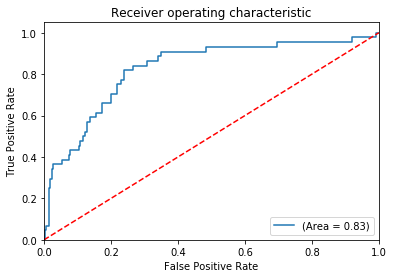

___________________________________________________



___________________ FOLD INDEX 8 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8055752589019719


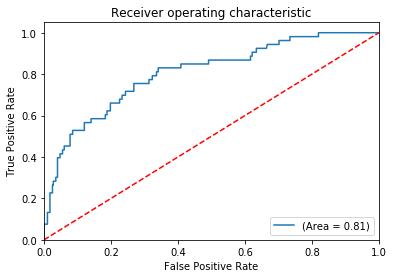


----- Classifier: Bernoulli NB -----
AUROC: 0.6012200312101007


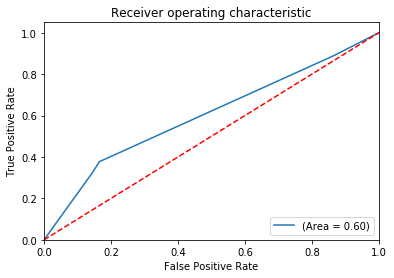


----- Classifier: Gaussian NB -----
AUROC: 0.8022650967040242


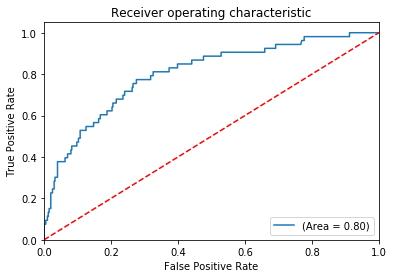

___________________________________________________



___________________ FOLD INDEX 9 ___________________

 Input data shape:
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

----- Classifier: Logistic Regression -----
AUROC: 0.8100822685104149


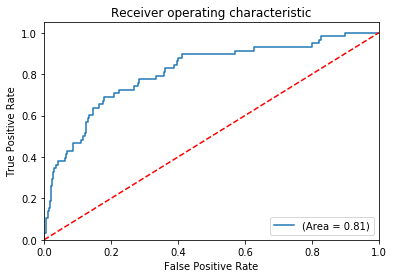


----- Classifier: Bernoulli NB -----
AUROC: 0.5860537370908455


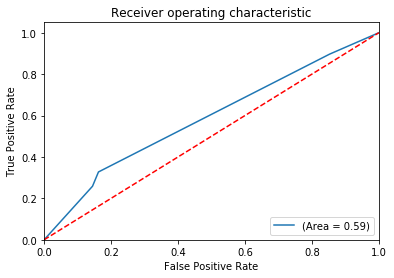


----- Classifier: Gaussian NB -----
AUROC: 0.7947663224225451


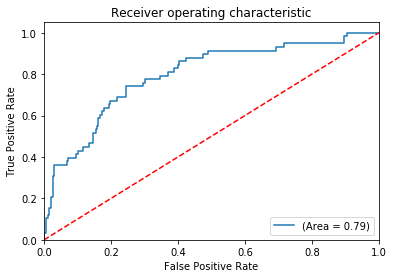

___________________________________________________




_____________ PERFORMANCE SUMMARY _____________
Average results from 10-fold cross-validation
Comparison method:      AUROC
Logistic Regression    0.825223
Bernoulli NB           0.613884
Gaussian NB            0.787530
dtype: float64


In [0]:
#compare the classifiers across different folds
cross_fold_val(model_data = model_data_2, classi_names = classifiers,\
               classi_params = classifiers_params, num_folds = 10)